In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from us import states

# Census & gmaps API Keys
from config import (api_key)

#pull tracts that were food deserts in 2010 and are not longer in 2015
tracts = ['011100', '009601', '007806', '007809', '009501', '002102', '007301', '007401','007603']

In [2]:
# Census original variables
variables = ["NAME", "B19013_001E",
             "B19058_002E", "B19301_001E", 
             "B17001_002E", "B17001_002E"]
        
# Rename each variables/fields        
renamed_variables = {"NAME": "Name",
                    "B19301_001E": "Income Per Capita",
                    "B19013_001E": "Median Household Income (past 12 months)",
                    "B19058_002E": "Public assistance/Food Stamps/SNAP (Number of Households)", 
                    "B17001_002E": "Income below Poverty Level (past 12 months)",
                     }

# 2010 - 2013 

In [3]:
# tracts = ['011100', '009601', '007806', '007809', '009501']
years1 = [2010, 2011, 2012, 2013]

converted_deserts_census_data1 = []

for yr1 in years1:
    c2009_2013 = Census(api_key, year=yr1)
    
    for tract in tracts:

        census_data_2009_2013 = c2009_2013.acs5.get((variables), 
                         {'for': f"tract:{tract}", 'in': 'state:{} county:001'.format(states.DC.fips)})        
        
        census_data_2009_2013[0].update({"year": yr1})       
        
        converted_deserts_census_data1.append(census_data_2009_2013[0])

# Put in the DataFrame
converted_deserts_census_2009_2013df = pd.DataFrame(converted_deserts_census_data1)
# Rename the columns
converted_deserts_census_2009_2013df = converted_deserts_census_2009_2013df.rename(columns=renamed_variables)

In [4]:
# Adjust to 2018 inflation rate
# Inflation-Adjusted Estimate = 2013 estimate * (2018 CPI-US-RS/2013 CPI-US-RS)
converted_deserts_census_2009_2013df['Median Household Income (past 12 months)'] = converted_deserts_census_2009_2013df['Median Household Income (past 12 months)'] * 1.07970803
converted_deserts_census_2009_2013df['Income Per Capita'] = converted_deserts_census_2009_2013df['Income Per Capita'] * 1.07970803


#converted_deserts_census_2009_2013df

# 2014 - 2018

In [5]:
#tracts = ['011100', '009601', '007806', '007809', '009501']
years = [2014, 2015, 2016, 2017, 2018]

converted_deserts_census_data = []

for yr in years:
    c2014_2018 = Census(api_key, year=yr)
    
    for tract in tracts:

        census_data_loop = c2014_2018.acs5.get((variables), 
                         {'for': f"tract:{tract}", 'in': 'state:{} county:001'.format(states.DC.fips)})
        
        census_data_loop[0].update({"year": yr})
        
        converted_deserts_census_data.append(census_data_loop[0])
        
converted_deserts_census_2014_2018df = pd.DataFrame(converted_deserts_census_data)
converted_deserts_census_2014_2018df = converted_deserts_census_2014_2018df.rename(columns=renamed_variables)
#converted_deserts_census_2014_2018df 

# 2010 - 2018

In [6]:
converted_deserts_census_all_years_df = pd.concat([converted_deserts_census_2014_2018df,converted_deserts_census_2009_2013df])
converted_deserts_census_all_years_df = converted_deserts_census_all_years_df.sort_values(['Name', 'year'])
#converted_deserts_census_all_years_df

In [7]:
cols_to_round = ['Median Household Income (past 12 months)', 'Public assistance/Food Stamps/SNAP (Number of Households)',
                 'Income Per Capita', 'Income below Poverty Level (past 12 months)'
                ]

In [8]:
# two decimals cleaning up
decimals = pd.Series([2, 2, 2, 2], index=cols_to_round)
censusIncome = converted_deserts_census_all_years_df.round(decimals)
censusIncome.head()

,Name,Median Household Income (past 12 months),Public assistance/Food Stamps/SNAP (Number of Households),Income Per Capita,Income below Poverty Level (past 12 months),state,county,tract,year
0,"Census Tract 111, District of Columbia, Distri...",59765.08,279.0,31398.99,444.0,11,001,011100,2010
9,"Census Tract 111, District of Columbia, Distri...",65071.84,278.0,33081.17,578.0,11,001,011100,2011
18,"Census Tract 111, District of Columbia, Distri...",63512.75,301.0,31425.98,615.0,11,001,011100,2012
27,"Census Tract 111, District of Columbia, Distri...",59500.55,327.0,30699.34,807.0,11,001,011100,2013
0,"Census Tract 111, District of Columbia, Distri...",58833.00,324.0,30272.00,870.0,11,001,011100,2014


In [9]:
# convert to CSV for All Data from 2010 - 2018
censusIncome.to_csv("income_data.csv", encoding='utf-8', index=False)

# Charts

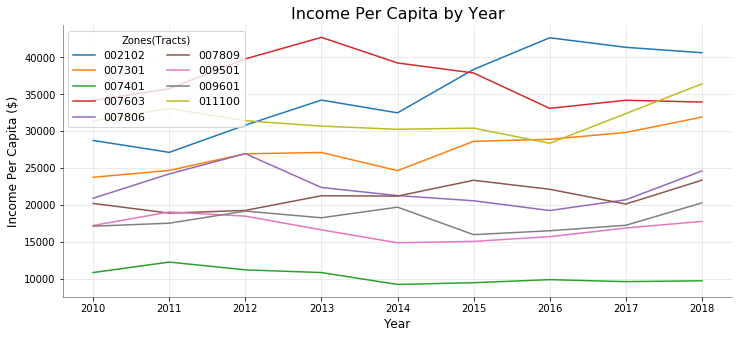

In [10]:
fig1, ax1 = plt.subplots(figsize=(12,5))
censusIncome.groupby(['year','tract']).mean()['Income Per Capita'].unstack().plot(ax=ax1)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Income Per Capita ($)', fontsize=12)
plt.title('Income Per Capita by Year', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(title='Zones(Tracts)',loc='best', ncol=2, fontsize=11)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5)   

plt.savefig('income_per_capita_ipynb')

plt.show()

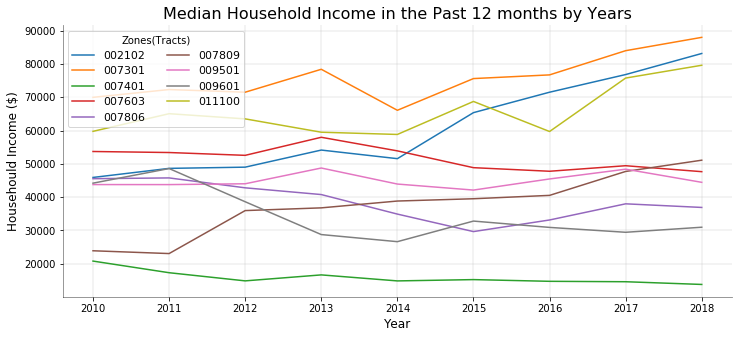

In [11]:
fig2, ax2 = plt.subplots(figsize=(12,5))
censusIncome.groupby(['year','tract']).mean()['Median Household Income (past 12 months)'].unstack().plot(ax=ax2)

plt.xlabel('Year',fontsize=12)
plt.ylabel('Househould Income ($)',fontsize=12)
plt.title('Median Household Income in the Past 12 months by Years',fontsize=16)
plt.grid(linewidth=0.3)
plt.legend(loc='best', ncol=2, fontsize=11)
plt.legend(title='Zones(Tracts)',loc='best', ncol=2, fontsize=11)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5) 

plt.savefig('median_household_income_ipynb')

plt.show()

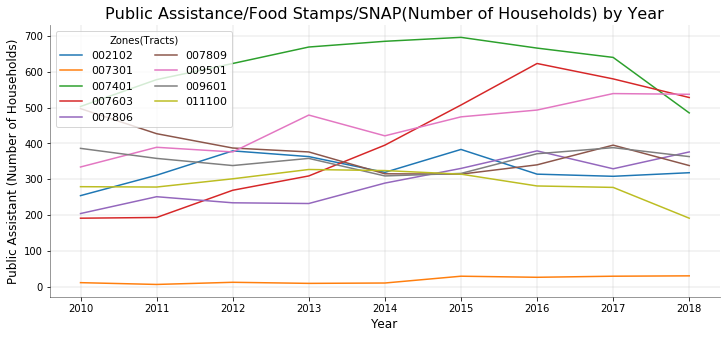

In [12]:
fig3, ax3 = plt.subplots(figsize=(12,5))
censusIncome.groupby(['year','tract']).mean()['Public assistance/Food Stamps/SNAP (Number of Households)'].unstack().plot(ax=ax3)

plt.xlabel('Year',fontsize=12)
plt.ylabel('Public Assistant (Number of Households)',fontsize=12)
plt.title('Public Assistance/Food Stamps/SNAP(Number of Households) by Year',fontsize=16)
plt.grid(linewidth=0.3)
plt.legend(loc='best', ncol=2, fontsize=11)
plt.legend(title='Zones(Tracts)',loc='best', ncol=2, fontsize=11)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5)

plt.savefig('public_assistance_ipynb')

plt.show()

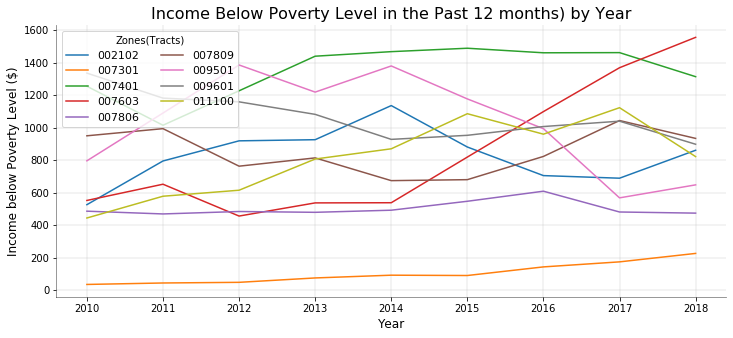

In [13]:
fig4, ax4 = plt.subplots(figsize=(12,5))
censusIncome.groupby(['year','tract']).mean()['Income below Poverty Level (past 12 months)'].unstack().plot(ax=ax4)

plt.xlabel('Year',fontsize=12)
plt.ylabel('Income below Poverty Level ($)',fontsize=12)
plt.title('Income Below Poverty Level in the Past 12 months) by Year',fontsize=16)
plt.grid(linewidth=0.3)
plt.legend(title='Zones(Tracts)',loc='best', ncol=2, fontsize=11)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5)
                                  
plt.savefig('income_below_poverty_level_ipynb')   


plt.show()

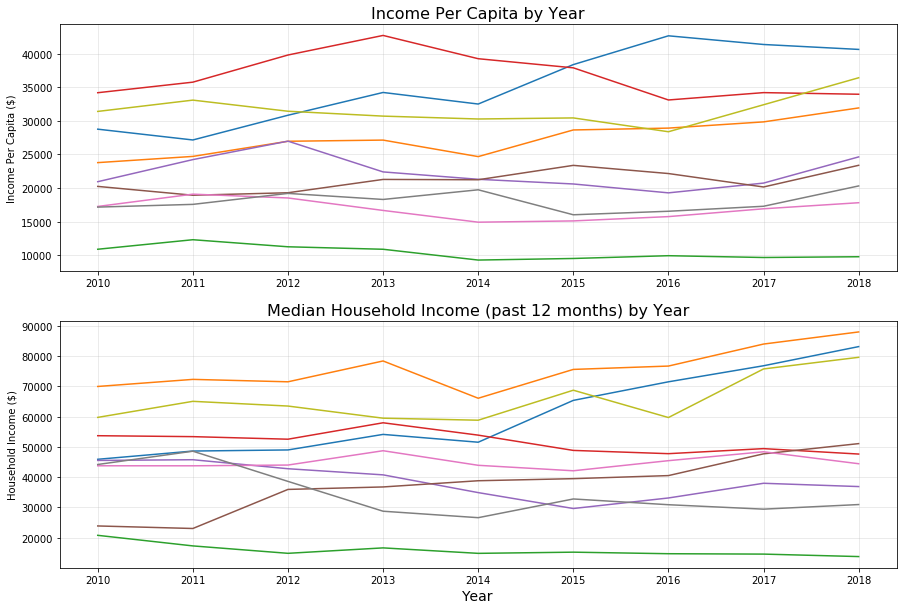

In [14]:
# Just wanna see if these two figs are going in to the same direction, don't need it
fig_5, ax5 = plt.subplots(2,1,figsize=(15,10))

ax5[0].plot(censusIncome.groupby(['year','tract']).mean()['Income Per Capita'].unstack())
ax5[1].plot(censusIncome.groupby(['year','tract']).mean()['Median Household Income (past 12 months)'].unstack())

plt.xlabel('Year',fontsize=14)
ax5[0].set_title('Income Per Capita by Year',fontsize=16)
ax5[1].set_title('Median Household Income (past 12 months) by Year',fontsize=16)

#ax.grid
ax5[0].grid(alpha=.3)
ax5[1].grid(alpha=.3)

#plt.legend(loc='best', ncol=2, fontsize=11)

ax5[0].set(ylabel='Income Per Capita ($)')
ax5[1].set(ylabel='Household Income ($)')

# Remove borders
#fig_5.gca().spines["top"].set_alpha(0.0)    
#fig_5.gca().spines["bottom"].set_alpha(0.5)
#fig_5.gca().spines["right"].set_alpha(0.0)    
#fig_5.gca().spines["left"].set_alpha(0.5)

plt.savefig('compare_income_ipynb')

plt.show()
#plt.savefig('fig_5.png')

In [15]:
'''
Income and earnings estimates in the 2009-2013 ACS 5-year data set are inflation-adjusted to 2013 dollars.  
Income and earnings estimates in the 2014-2018 ACS 5-year data set are inflation-adjusted to 2018 dollars.  
To compare income estimates between the two, 
multiply the 2009-2013 dollar estimates by 1.07970803 (CPI-U-RS) 
in order to inflation-adjust 2013 dollars to 2018 dollars. 
The exception is the Comparative Economic Characteristics Profile (CP03) 
where all income and earnings dollar values are presented in 2018 inflation-adjusted dollars. 
Note that the Census Bureau inflation-adjusts microdata to arrive at the adjusted dollar values in CP03.  
Data users will not be able to exactly replicate the CP03 2009-2013 inflation-adjusted values
'''

'\nIncome and earnings estimates in the 2009-2013 ACS 5-year data set are inflation-adjusted to 2013 dollars.  \nIncome and earnings estimates in the 2014-2018 ACS 5-year data set are inflation-adjusted to 2018 dollars.  \nTo compare income estimates between the two, \nmultiply the 2009-2013 dollar estimates by 1.07970803 (CPI-U-RS) \nin order to inflation-adjust 2013 dollars to 2018 dollars. \nThe exception is the Comparative Economic Characteristics Profile (CP03) \nwhere all income and earnings dollar values are presented in 2018 inflation-adjusted dollars. \nNote that the Census Bureau inflation-adjusts microdata to arrive at the adjusted dollar values in CP03.  \nData users will not be able to exactly replicate the CP03 2009-2013 inflation-adjusted values\n'

In [16]:
groupbyYear = converted_deserts_census_all_years_df.groupby(['year']).mean()
groupbyYear_df = pd.DataFrame(groupbyYear)

In [17]:
groupbyYear_df['%pct Median Household Income'] = groupbyYear_df['Median Household Income (past 12 months)'].pct_change()
groupbyYear_df['%pct Public Assistance'] = groupbyYear_df['Public assistance/Food Stamps/SNAP (Number of Households)'].pct_change()
groupbyYear_df['%pct Income Per Capita'] = groupbyYear_df['Income Per Capita'].pct_change()
groupbyYear_df['%pct Income Below Poverty Level'] = groupbyYear_df['Income below Poverty Level (past 12 months)'].pct_change()
pct_df = groupbyYear_df.fillna(0)
pct_df.reset_index()

,year,Median Household Income (past 12 months),Public assistance/Food Stamps/SNAP (Number of Households),Income Per Capita,Income below Poverty Level (past 12 months),%pct Median Household Income,%pct Public Assistance,%pct Income Per Capita,%pct Income Below Poverty Level
0,2010,45278.515979,295.444444,22728.573837,708.888889,0.000000,0.000000,0.000000,0.000000
1,2011,46428.884901,310.111111,23640.327284,757.666667,0.025407,0.049643,0.040115,0.068809
2,2012,45864.317569,324.333333,24913.183084,784.111111,-0.012160,0.045862,0.053843,0.034902
3,2013,46852.850254,346.888889,24916.422208,819.888889,0.021553,0.069544,0.000130,0.045628
4,2014,43270.888889,340.777778,23678.777778,842.000000,-0.076451,-0.017617,-0.049672,0.026968
5,2015,46429.888889,373.666667,24433.111111,858.000000,0.073005,0.096511,0.031857,0.019002
6,2016,46714.888889,388.111111,24072.777778,866.777778,0.006138,0.038656,-0.014748,0.010231
7,2017,51571.555556,387.222222,24721.888889,883.333333,0.103964,-0.002290,0.026965,0.019100
8,2018,52842.666667,351.777778,26532.000000,859.222222,0.024648,-0.091535,0.073219,-0.027296


In [18]:
cols_to_round2 = ['Median Household Income (past 12 months)', 'Public assistance/Food Stamps/SNAP (Number of Households)',
                 'Income Per Capita', 'Income below Poverty Level (past 12 months)',
                 '%pct Median Household Income', '%pct Public Assistance',
                 '%pct Income Per Capita', '%pct Income Below Poverty Level'
                ]

In [19]:
# two decimals cleaning up
decimals = pd.Series([2, 2, 2, 2, 2, 2, 2, 2], index=cols_to_round2)
censusIncome2 = pct_df.round(decimals)

In [20]:
censusIncome2 = censusIncome2[["Income Per Capita", "%pct Income Per Capita",
                               "Median Household Income (past 12 months)", "%pct Median Household Income",
                              "Income below Poverty Level (past 12 months)", "%pct Income Below Poverty Level",
                              "Public assistance/Food Stamps/SNAP (Number of Households)",
                              "%pct Public Assistance"]]

In [21]:
censusIncome3 = censusIncome2.reset_index()

In [22]:
# convert to CSV for All Data from 2010 - 2018
censusIncome3.to_csv("income_data_with_pct_change.csv", encoding='utf-8', index=False)

In [23]:
censusIncome3

,year,Income Per Capita,%pct Income Per Capita,Median Household Income (past 12 months),%pct Median Household Income,Income below Poverty Level (past 12 months),%pct Income Below Poverty Level,Public assistance/Food Stamps/SNAP (Number of Households),%pct Public Assistance
0,2010,22728.57,0.00,45278.52,0.00,708.89,0.00,295.44,0.00
1,2011,23640.33,0.04,46428.88,0.03,757.67,0.07,310.11,0.05
2,2012,24913.18,0.05,45864.32,-0.01,784.11,0.03,324.33,0.05
3,2013,24916.42,0.00,46852.85,0.02,819.89,0.05,346.89,0.07
4,2014,23678.78,-0.05,43270.89,-0.08,842.00,0.03,340.78,-0.02
5,2015,24433.11,0.03,46429.89,0.07,858.00,0.02,373.67,0.10
6,2016,24072.78,-0.01,46714.89,0.01,866.78,0.01,388.11,0.04
7,2017,24721.89,0.03,51571.56,0.10,883.33,0.02,387.22,-0.00
8,2018,26532.00,0.07,52842.67,0.02,859.22,-0.03,351.78,-0.09


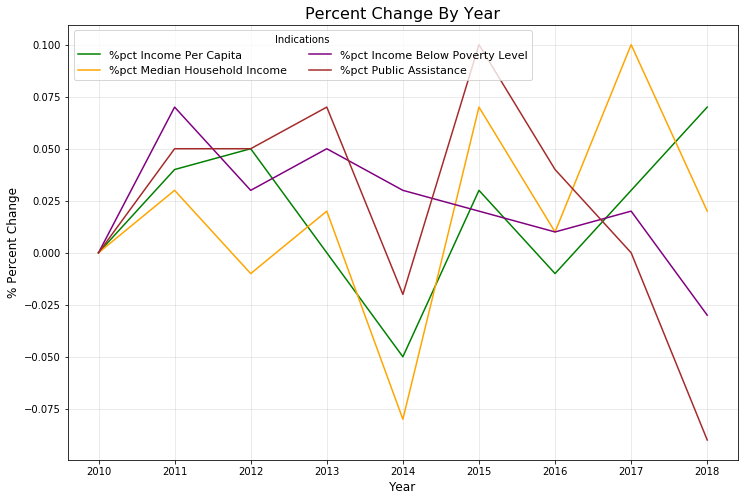

In [24]:
fig_6, ax6 = plt.subplots(1,1,figsize=(12,8))

ax6 = plt.gca()

censusIncome3.plot(kind='line',x='year',y='%pct Income Per Capita',color='green', ax=ax6)
censusIncome3.plot(kind='line',x='year',y='%pct Median Household Income', color='orange', ax=ax6)
censusIncome3.plot(kind='line',x='year',y='%pct Income Below Poverty Level', color='purple', ax=ax6)
censusIncome3.plot(kind='line',x='year',y='%pct Public Assistance', color='brown', ax=ax6)


plt.title('Percent Change By Year', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(title='Indications',loc='best', ncol=2, fontsize=11)
ax6.set_ylabel('% Percent Change', fontsize=12)
ax6.set_xlabel('Year', fontsize=12)

plt.savefig('pct_change_by_year_ipynb')

plt.show()